In [73]:
import numpy as np
import pennylane as qml
import itertools
from VQT import prob_dist
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

In [74]:
number = '1'
back_str = 'ibm_lagos'
date = '2021-09-28'

engine = "heat_accelerator"

file_heat_counts = open(f'final_results/{engine}/{number}_heat_non_{date}_{back_str}', 'rb')
file_work_counts = open(f'final_results/{engine}/{number}_work_non_{date}_{back_str}', 'rb')

file_c_probs = open(f'final_results/{engine}/{number}_prob_heat_{date}_{back_str}', 'rb')
file_h_probs = open(f'final_results/{engine}/{number}_prob_work_{date}_{back_str}', 'rb')

file_sys_params = open(f'final_results/{engine}/{number}_sys_params_{date}_{back_str}', 'rb')

# load information from the files
counts_heat = pickle.load(file_heat_counts)
counts_work = pickle.load(file_work_counts)

dist_params_c = pickle.load(file_c_probs)
dist_params_h = pickle.load(file_h_probs)

sys_params = pickle.load(file_sys_params)

file_heat_counts.close()
file_work_counts.close()
file_c_probs.close()
file_h_probs.close()
file_sys_params.close()

In [75]:
Iqml = np.identity(2)
Zqml = np.array([[1,0],[0,-1]])

#Temperature
Tc = sys_params["Tc"]
Th = sys_params["Th"]

beta_c = 1/Tc # 1/Tc
beta_h = 1/Th # 1/Th

# Parameters
w1 = sys_params["w1"]
w2 = sys_params["w2"]
wc = w1
wh = w2

gch = sys_params["gch"]
g12 = sys_params["g12"]

# Strokes durations
tq = sys_params["tq"]
tw = sys_params["tw"]

# Number of Measurement
N = sys_params["N"]

#Trotter steps
M = 1

H1 = (w1 / 2) * Zqml
H2 = (w2 / 2) * Zqml

Hc = (wc / 2) * Zqml
Hh = (wh / 2) * Zqml

if Tc/Th <= w1/w2 and w1/w2 <= 1:
    print("The system is a heat engine.")
    system = 'heat_engine'
elif w1/w2 < Tc/Th:
    print("The system is a refrigerator.")
    system = 'refrigerator'
elif w1>w2:
    print("The system is a heat accelerator.")
    system = 'heat_accelerator'

The system is a heat accelerator.


In [76]:
# import pickle

# def save_results(results,name):
#     with open('final_results/'+str(name),'wb') as f:
#         pickle.dump(results, f)        

In [77]:
# sys_params = {"Tc": Tc, "Th": Th, "w1": w1, "w2": w2, "gch": gch, "g12": g12, "tq": tq, "tw": tw, "N": N}
# save_results(sys_params, number+'_'+'sys_params_' + back_str + '_' + date)

In [78]:
thermal_circs = ['circ']*4
n_exps = 10
shots = 8192

In [79]:
def dict_reduction(counts_dict,qubit):
    """Computes all counts for a given basis element:

    Args:
        counts_dict (dict): dictionary to be reducted
        qubit (int): measured qubit

    Returns:
        dict: The reduced dictionary
    """
    
    dict_red = {}
    for i in ['0', '1']:
        value = 0
        for key in counts_dict:
            if key[qubit] == i:
                value += counts_dict[key]
                dict_red[i] = value
    return dict_red

In [80]:
combos = itertools.product([0, 1], repeat=2)
s = [list(c) for c in combos]

dist_final = prob_dist([dist_params_c,dist_params_h])

def z_expval(counts_stroke,meas_qubit):
    #Obtaining ZI and IZ for each sample
    Z_samples = []
    for k in range(len(thermal_circs)):
        Z_aux = []
        for counts in counts_stroke[k]:
            counts = dict_reduction(counts,meas_qubit)
            # calculate the probabilities for each qubit value
            probs = {}
            for output in ['0', '1']:
                if output in counts:
                    probs[output] = counts[output]/shots
                else:
                    probs[output] = 0

            Z_aux.append(probs['0']-probs['1'])

        Z_samples.append(Z_aux)

    Z_samples = np.array(Z_samples).transpose()

    #Obtaining <Z> from the samples
    Z_vals = []
    for Z_samp in Z_samples:
        Z_final = 0
        for i, sample in zip(s,Z_samp):
            dist_aux = 1
            for j in range(0, len(i)):
                dist_aux = dist_final[j][i[j]]*dist_aux
            Z_final = Z_final + dist_aux*sample

        Z_vals.append(Z_final)
        
    return Z_vals

In [81]:
# Quantum chain
Z1_heat, Z2_heat, Z1_work, Z2_work = [], [], [], []
for c_heat, c_work in zip(counts_heat, counts_work):
    Z1_res, Z2_res = z_expval(c_heat,meas_qubit=1), z_expval(c_heat,meas_qubit=2)
    Z1_heat.append(Z1_res)
    Z2_heat.append(Z2_res)
    
    Z1_res, Z2_res = z_expval(c_work,meas_qubit=1), z_expval(c_work,meas_qubit=2)   
    Z1_work.append(Z1_res)
    Z2_work.append(Z2_res)

In [82]:
%run ./2_qubits/1-strob_theory.ipynb

Classical simulation is finished.


In [83]:
Qc_exps = []
Qh_exps = []
W_exps = []

for j in range(N):
    Qc_aux = []
    Qh_aux = []
    W_aux = []
    for i in range(n_exps):
        if j == 0:
            Qc_aux.append((wc/2)*(Z1_heat[i][j+1] - Z1_heat[i][j]))
            Qh_aux.append((wh/2)*(Z2_heat[i][j+1] - Z1_heat[i][j]))
        else:
            Qc_aux.append((wc/2)*(Z1_heat[i][j+1] - Z1_work[i][j-1]))
            Qh_aux.append((wh/2)*(Z2_heat[i][j+1] - Z2_work[i][j-1]))
    
        W_aux.append(-(wc/2)*(Z1_work[i][j]-Z1_heat[i][j+1])-(wh/2)*(Z2_work[i][j]-Z2_heat[i][j+1]))
        
    Qc_exps.append(Qc_aux)
    Qh_exps.append(Qh_aux)
    W_exps.append(W_aux)

In [84]:
Qc, Qc_err = [], []
Qh, Qh_err = [], []
W, W_err = [], []
for i in range(N):
    #Mean values
    Qc.append(np.mean(Qc_exps[i]))
    Qh.append(np.mean(Qh_exps[i]))
    W.append(np.mean(W_exps[i]))
    #Standard deviations of the mean
    Qc_err.append(3*np.std(Qc_exps[i])/np.sqrt(n_exps))
    Qh_err.append(3*np.std(Qh_exps[i])/np.sqrt(n_exps))
    W_err.append(3*np.std(W_exps[i])/np.sqrt(n_exps))

In [85]:
sns.set_theme()
sns.set_context("paper", font_scale = 2)

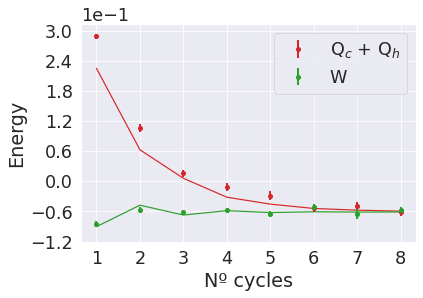

In [86]:
fig, axes = plt.subplots(1,1)

Ns = np.linspace(1,N,N)

Q_err = np.array(Qc_err) + np.array(Qh_err)
Q_sum = np.array(Qc) + np.array(Qh)

Qs_sum = np.array(Qc_sim) + np.array(Qh_sim)

#QuTip
axes.plot(Ns, Qs_sum, color='tab:red')
axes.plot(Ns, W_sim, color='tab:green')

axes.errorbar(Ns, Q_sum, yerr=Q_err, marker='.', linestyle='', color='tab:red', label='Q$_c$ + Q$_h$'
             , markersize=8, elinewidth = 2)
axes.errorbar(Ns, W, yerr=W_err, marker='.', linestyle='', color='tab:green', label='W'
             , markersize=8, elinewidth = 2)
axes.legend(loc=1);
axes.set_xlabel('Nº cycles')
axes.set_ylabel('Energy')
axes.set_xticks([1,2,3,4,5,6,7,8])

#yticks
if system == "heat_engine":
    axes.set_yticks([0,0.04,0.08,0.12,0.16,0.2])
elif system == "refrigerator":
    axes.set_yticks([-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.25])
elif system == "heat_accelerator":
    axes.set_yticks([-0.12,-0.06,0,0.06,0.12,0.18,0.24,0.3])

axes.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(f'final_results/{engine}/{number}_{engine}_{date}_{back_str}_first_law.png', bbox_inches='tight')

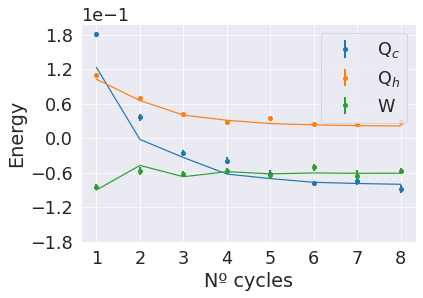

In [87]:
fig, axes = plt.subplots(1,1)

Ns = np.linspace(1,N,N)

#QuTip
axes.plot(Ns, Qc_sim, color='tab:blue')
axes.plot(Ns, Qh_sim, color='tab:orange')
axes.plot(Ns, W_sim, color='tab:green')
#Qiskit
axes.errorbar(Ns, Qc, yerr=Qc_err, marker='.', linestyle='', color='tab:blue', label='Q$_c$'
              , markersize=8, elinewidth = 2)
axes.errorbar(Ns, Qh, yerr=Qh_err, marker='.', linestyle='', color='tab:orange', label='Q$_h$'
              , markersize=8, elinewidth = 2)
axes.errorbar(Ns, W, yerr=W_err, marker='.', linestyle='', color='tab:green', label='W'
              , markersize=8, elinewidth = 2)

axes.set_xlabel('Nº cycles')
axes.set_ylabel('Energy')
axes.legend(loc=1);
axes.set_xticks([1,2,3,4,5,6,7,8])

#yticks
if system == "heat_engine":
    set_list = np.linspace(-0.05,0.15,9)
    axes.set_yticks(set_list)
elif system == "refrigerator":
    set_list = np.linspace(-0.12,0.16,8)
    axes.set_yticks(set_list)
elif system == "heat_accelerator":
    #axes.set_yticks([-0.03,0,0.03,0.06,0.09,0.12,0.15])
    axes.set_yticks([-0.18, -0.12, -0.06, 0, 0.06, 0.12, 0.18])

axes.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(f'final_results/{system}/{number}_{system}_{date}_{back_str}.png', bbox_inches='tight')